In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import requests
import time
import os.path
import pickle

In [2]:
df = pd.read_csv("mock_data.csv")

In [42]:
df2 = pd.read_csv("data.csv")

In [26]:
df2.head()

,Class,Ecosystem,Species,Genus,Order
0,Mammals,Savannahs,Zebra,Equus,Perissodactyla
1,Mammals,Savannahs,Giraffe,Giraffa,Artiodactyla
2,Mammals,Savannahs,Elephant,Loxodonta,Proboscidea
3,Mammals,Savannahs,Hyena,Hyaena,Carnivora
4,Mammals,Savannahs,Lion,Panthera,Carnivora


In [70]:
def load_cache():
    pickle_path = "data_cache.pkl"
    file_exists = os.path.exists(pickle_path)
    if file_exists:
        with open( pickle_path, 'rb') as f:
            print(f"loading cache from {pickle_path}")
            return pickle.load(f)
    else:
        return {}
    
cache = load_cache()

loading cache from data_cache.pkl


In [68]:
def save_cache(cache):
    pickle_path = "data_cache.pkl"
    with open(pickle_path, 'wb') as f:
        pickle.dump(cache, f, pickle.HIGHEST_PROTOCOL)
save_cache(cache)

In [62]:
# generates a list of species name grouped by col_name
def gen_sets_by_col(df, col_name):
    classes = df[col_name].unique()
    all_set = []
    for c in classes:
        s = list(df[df[col_name] == c]["Species"])
        all_set.extend(s)
    return all_set

# TODO: what if the page doesn't exists?
def findDegrees(source, target):
    payload = {"source": source, "target": target}
    headers = {'Accept': 'application/json, text/plain, */*', 'Content-Type': 'application/json;charset=UTF-8'}
    url = 'https://api.sixdegreesofwikipedia.com/paths'
    response = requests.post(url, data=json.dumps(payload), headers=headers)
    number_of_degrees = len(response.json()['paths'][0]) - 1
    number_of_paths = len(response.json()['paths'])

    occurrences = [0, 0, 0]

    if number_of_degrees == 1:
        occurrences[0] = number_of_paths
    elif number_of_degrees == 2:
        occurrences[1] = number_of_paths
    else:
        occurrences[2] = number_of_paths

    return occurrences


# calculates the similarity
def sim(source, target):
    print(f"findDegrees: {source} to {target} -----")
    # TODO: find appropriate weights
    # explain in report why those weights are chosen
    w = np.array([100, 10, 1])
    pair1 = (source, target)
    pair2 = (target, source)
    if pair1 in cache:
        d1 = cache[pair1]
    else:
        d1 = np.asarray(findDegrees(source, target))
        cache[pair1] = d1
    if pair2 in cache:
        d2 = cache[pair2]
    else:
        d2 = np.asarray(findDegrees(target, source))
        cache[pair2] = d2
    avg_link = (d1 + d2) / 2
    print(avg_link)
    return np.sum(w * avg_link)

# generate the simularity matrix
# Note that the matrix is symmetric because sim(x,y) == sim(y,x)
def gen_matrix(lst):
    n = len(lst)
    arr = np.zeros((n,n))
    for i in range(n):
        for j in range(i + 1):
            if arr[i][j] != 0:
                continue
            if (i == j):
                # TODO: hard a sensible value
                # arr[i][i] = sim(lst[i], lst[i])
                arr[i][i] = 100
            else:
                t = sim(lst[i], lst[j])
                arr[i][j] = t
                arr[j][i] = t
    return arr

# generates a meatmap from the data frame df grouped by col_name
def gen_heatmap(df,col_name):
    lst = gen_sets_by_col(df, col_name)
    start_time = time.time()
    sim_mat = gen_matrix(lst)
    end_time = time.time()
    print(f"time matrix creation time: {end_time - start_time} sec")
    ax = sns.heatmap(sim_mat, cbar_kws={'label': 'Similarity value'})
    plt.xlabel("index of animal") 
    plt.ylabel("index of animal")
    plt.title(f"Similarities between animals by {col_name}")
    plt.show() 

findDegrees: Rhino to Hippo -----
[1. 0. 0.]
findDegrees: Lion to Hippo -----
[1. 0. 0.]
findDegrees: Lion to Rhino -----
[0.5 9.5 0. ]
findDegrees: Leopard to Hippo -----
[ 0.  46.5  0. ]
findDegrees: Leopard to Rhino -----
[ 0. 18.  0.]
findDegrees: Leopard to Lion -----
[1. 0. 0.]
findDegrees: Black Mamba to Hippo -----
[0.  3.5 0. ]
findDegrees: Black Mamba to Rhino -----
[0. 3. 0.]
findDegrees: Black Mamba to Lion -----
[ 0. 11.  0.]
findDegrees: Black Mamba to Leopard -----
[0.  7.5 0. ]
findDegrees: Puff Adder to Hippo -----
[0.  3.5 0. ]
findDegrees: Puff Adder to Rhino -----
[ 0.  4. 30.]
findDegrees: Puff Adder to Lion -----
[0.  7.5 0. ]
findDegrees: Puff Adder to Leopard -----
[0. 6. 0.]
findDegrees: Puff Adder to Black Mamba -----
[0.  4.5 0. ]
findDegrees: Cape Cobra to Hippo -----
[0.  1.5 9.5]
findDegrees: Cape Cobra to Rhino -----
[0.  1.5 3.5]
findDegrees: Cape Cobra to Lion -----
[ 0.   5.  12.5]
findDegrees: Cape Cobra to Leopard -----
[ 0.   3.  11.5]
findDegrees: 

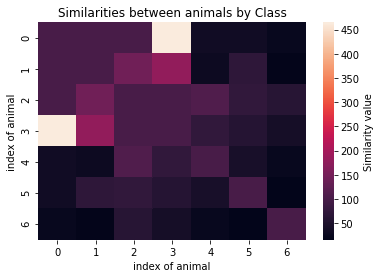

In [71]:
# heat map for test data
gen_heatmap(df, "Class")

In [43]:
# heat map for actual data
gen_heatmap(df2, "Ecosystem", arr)

findDegrees: Giraffe to Zebra -----
[ 0. 20.  0.]
findDegrees: Elephant to Zebra -----
[ 0.  17.5  0. ]
findDegrees: Elephant to Giraffe -----
[ 0.5 13.5  0. ]
findDegrees: Hyena to Zebra -----
[0.5 2.5 0. ]
findDegrees: Hyena to Giraffe -----
[ 0.  24.5  0. ]
findDegrees: Hyena to Elephant -----
[ 0.5 11.   0. ]
findDegrees: Lion to Zebra -----
[ 0.5 10.   0. ]
findDegrees: Lion to Giraffe -----
[1. 0. 0.]
findDegrees: Lion to Elephant -----
[1. 0. 0.]
findDegrees: Lion to Hyena -----
[1. 0. 0.]
findDegrees: Nile Crocodile to Zebra -----
[ 0.5 11.   0. ]
findDegrees: Nile Crocodile to Giraffe -----
[1. 0. 0.]
findDegrees: Nile Crocodile to Elephant -----
[ 0.  16.5  0. ]
findDegrees: Nile Crocodile to Hyena -----
[0.5 2.5 0. ]
findDegrees: Nile Crocodile to Lion -----
[1. 0. 0.]
findDegrees: Leopard Tortoise to Zebra -----
[0. 1. 0.]
findDegrees: Leopard Tortoise to Giraffe -----
[0.  1.5 0. ]
findDegrees: Leopard Tortoise to Elephant -----
[ 0.   3.5 63.5]
findDegrees: Leopard Tortoi

[  0.    0.5 114. ]
findDegrees: Cougar to verreaux's eagle owl -----
[ 0. 11.  0.]
findDegrees: Cougar to Lappet-faced Vulture -----
[ 0.   1.5 73.5]
findDegrees: Cougar to Capybara -----
[0.5 3.5 0. ]
findDegrees: Otter to Zebra -----
[0.  7.5 0. ]
findDegrees: Otter to Giraffe -----
[0.  8.5 0. ]
findDegrees: Otter to Elephant -----
[ 0.  10.5  0. ]
findDegrees: Otter to Hyena -----
[1. 0. 0.]
findDegrees: Otter to Lion -----
[1. 0. 0.]
findDegrees: Otter to Nile Crocodile -----
[ 0. 14.  0.]
findDegrees: Otter to Leopard Tortoise -----
[ 0.   1.5 27.5]
findDegrees: Otter to Black Mamba -----
[0. 3. 0.]
findDegrees: Otter to Komodo dragon -----
[  0.   2. 174.]
findDegrees: Otter to jackson's chameleon -----
[ 0.  0. 90.]
findDegrees: Otter to African Fish Eagle -----
[0. 2. 0.]
findDegrees: Otter to Ostrich -----
[0. 2. 0.]
findDegrees: Otter to Coppery-tailed coucal -----
[ 0.  0. 98.]
findDegrees: Otter to verreaux's eagle owl -----
[ 0. 10.  0.]
findDegrees: Otter to Lappet-face

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [44]:
# test specific pair
sim("Pit Viper", "Otter")

findDegrees: Pit Viper to Otter -----
[  0.    0.5 177. ]


182.0